In [1]:
# Import libraries
import netCDF4 as nc
import xarray as xr
import pygrib
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta
import matplotlib.patheffects as path_effects
import numpy as np
import cartopy.util as cutil
import xarray as xr
import pandas as pd
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
import matplotlib.colors as colors
import sys
import warnings
import cdsapi

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, Hodograph, SkewT
from metpy.units import units

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [ ]:
# file path: /scratch/mch/fackerma/orders/case_150619/ERA5_data/b541aa3b6053349d4f3e4b45bd287d1a.nc
# Load the dataset
file_path = "/scratch/mch/fackerma/orders/case_150619/ERA5_data/b541aa3b6053349d4f3e4b45bd287d1a.nc"
df = xr.open_dataset(file_path)

In [ ]:

df=df.assign(t_c=lambda df: df.t - 273.15)
df=df.assign(d_c=lambda df: (237.3 * (np.log(df.r / 100) + (17.27 * df.t_c) / (237.3 + df.t_c))) / \
           (17.27 - (np.log(df.r / 100) + (17.27 * df.t_c) / (237.3 + df.t_c))))
df=df.assign(wind_speed=lambda df: (df.u**2 + df.v**2)**0.5 )
df=df.assign(wind_direction=lambda df: (np.degrees(np.arctan2(-df.u, -df.v)) + 360) % 360)
# Constants
R_d = 287.05  # Specific gas constant for dry air, J/(kg*K)
g = 9.80665   # Gravitational acceleration, m/s^2
P_surface = 1000  # Reference surface pressure in hPa
# Calculate height in meters for each pressure level
df = df.assign(
    height=lambda df: (R_d * df.t / g) * np.log(P_surface / df.pressure_level)
)

# Convert the DataFrame to an xarray Dataset
#ds = xr.Dataset.from_dataframe(df)

# Save the Dataset as a .nc file
#ds.to_netcdf("/scratch/mch/fackerma/orders/case_150619/ERA5_data/ERA5_VP1.nc")


AttributeError: 'Dataset' object has no attribute 'columns'

In [ ]:
#file_path = "/scratch/mch/fackerma/orders/case_150619/ERA5_data/ERA5_VP1.nc"
#df = xr.open_dataset(file_path)

In [36]:
# Select data for Geneva (approximate coordinates) and specific time
location = 'Geneva'
latitude, longitude = 46.2044, 6.1432
valid_time = "2019-06-15T14:00:00"
day = '2019-06-15'
hour = '1400'

subset = df.sel(latitude=latitude, longitude=longitude, valid_time=valid_time, method="nearest")

p = subset['pressure_level'].values * units.hPa
z = subset['height'].values * units.m
T = subset['t_c'].values * units.degC
Td = subset['d_c'].values * units.degC
wind_speed = subset['wind_speed'].values * units.meter_per_second
wind_dir = subset['wind_direction'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)
r = subset['r'].values


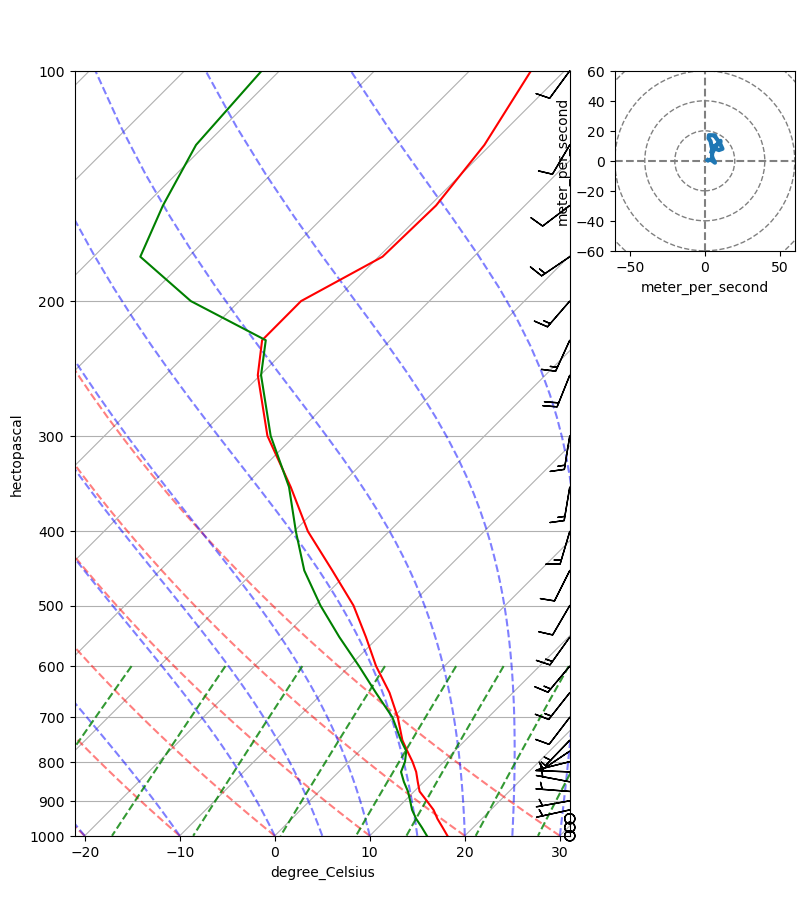

In [9]:
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=45, rect=(0.1, 0.1, 0.55, 0.85))

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)

# Change to adjust data limits and give it a semblance of what we want
skew.ax.set_adjustable('datalim')
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-20, 30)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Create a hodograph
ax = plt.axes((0.7, 0.75, 0.2, 0.2))
h = Hodograph(ax, component_range=60.)
h.add_grid(increment=20)
h.plot(u, v)

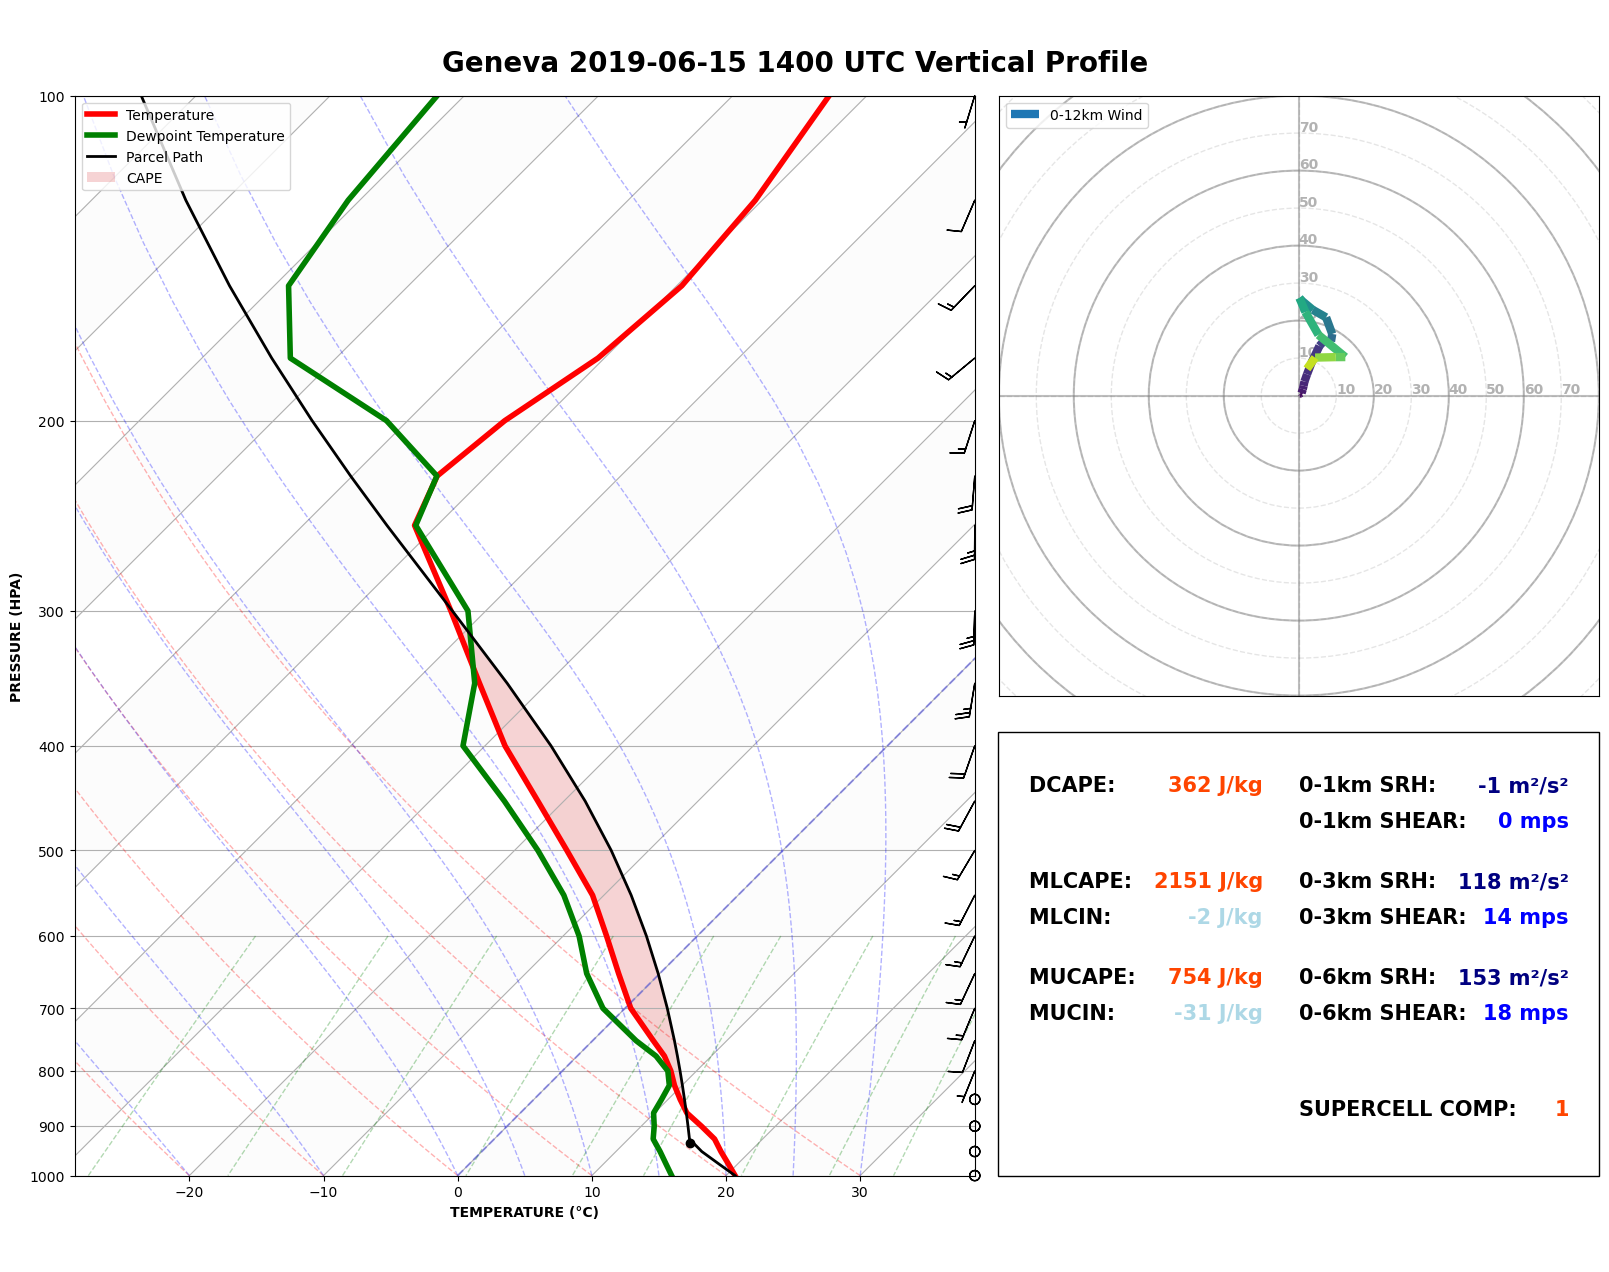

In [ ]:
# STEP 1: CREATE THE SKEW-T OBJECT AND MODIFY IT TO CREATE A
# NICE, CLEAN PLOT
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(18, 12))
skew = SkewT(fig, rotation=45, rect=(0.05, 0.05, 0.50, 0.90))

# Change to adjust data limits and give it a semblance of what we want
skew.ax.set_adjustable('datalim')
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-20, 30)

# Set some better labels than the default to increase readability
skew.ax.set_xlabel(str.upper(f'Temperature ({T.units:~P})'), weight='bold')
skew.ax.set_ylabel(str.upper(f'Pressure ({p.units:~P})'), weight='bold')

# Set the facecolor of the skew-t object and the figure to white
fig.set_facecolor('#ffffff')
skew.ax.set_facecolor('#ffffff')

# Here we can use some basic math and Python functionality to make a cool
# shaded isotherm pattern.
x1 = np.linspace(-100, 40, 8)
x2 = np.linspace(-90, 50, 8)
y = [1100, 50]
for i in range(0, 8):
    skew.shade_area(y=y, x1=x1[i], x2=x2[i], color='gray', alpha=0.02, zorder=1)

# STEP 2: PLOT DATA ON THE SKEW-T. TAKE A COUPLE EXTRA STEPS TO
# INCREASE READABILITY
# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
# Set the linewidth to 4 for increased readability.
# We will also add the 'label' keyword argument for our legend.
skew.plot(p, T, 'r', lw=4, label='Temperature')
skew.plot(p, Td, 'g', lw=4, label='Dewpoint Temperature')

# Again we can use some simple Python math functionality to 'resample'
# the wind barbs for a cleaner output with increased readability.
# Something like this would work.
interval = np.logspace(2, 3, 40) * units.hPa
idx = mpcalc.resample_nn_1d(p, interval)
skew.plot_barbs(pressure=p[idx], u=u[idx], v=v[idx])

# Add the relevant special lines native to the Skew-T Log-P diagram &
# provide basic adjustments to linewidth and alpha to increase readability
# first, we add a matplotlib axvline to highlight the 0-degree isotherm
skew.ax.axvline(0 * units.degC, linestyle='--', color='blue', alpha=0.3)
skew.plot_dry_adiabats(lw=1, alpha=0.3)
skew.plot_moist_adiabats(lw=1, alpha=0.3)
skew.plot_mixing_lines(lw=1, alpha=0.3)

# Calculate LCL height and plot as a black dot. Because `p`'s first value is
# ~1000 mb and its last value is ~250 mb, the `0` index is selected for
# `p`, `T`, and `Td` to lift the parcel from the surface. If `p` was inverted,
# i.e. start from a low value, 250 mb, to a high value, 1000 mb, the `-1` index
# should be selected.
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')
# Calculate full parcel profile and add to plot as black line
prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2, label='Parcel Path')

# Shade areas of CAPE and CIN
#skew.shade_cin(p, T, prof, Td, 
               #alpha=0.2, label='CIN')
skew.shade_cape(p, T, prof, alpha=0.2, label='CAPE')

# STEP 3: CREATE THE HODOGRAPH INSET. TAKE A FEW EXTRA STEPS TO
# INCREASE READABILITY
# Create a hodograph object: first we need to add an axis
# then we can create the Metpy Hodograph
hodo_ax = plt.axes((0.48, 0.45, 0.5, 0.5))
h = Hodograph(hodo_ax, component_range=80.)

# Add two separate grid increments for a cooler look. This also
# helps to increase readability
h.add_grid(increment=20, ls='-', lw=1.5, alpha=0.5)
h.add_grid(increment=10, ls='--', lw=1, alpha=0.2)

# The next few steps makes for a clean hodograph inset, removing the
# tick marks, tick labels, and axis labels
h.ax.set_box_aspect(1)
h.ax.set_yticklabels([])
h.ax.set_xticklabels([])
h.ax.set_xticks([])
h.ax.set_yticks([])
h.ax.set_xlabel(' ')
h.ax.set_ylabel(' ')

# Here we can add a simple Python for loop that adds tick marks
# to the inside of the hodograph plot to increase readability!
plt.xticks(np.arange(0, 0, 1))
plt.yticks(np.arange(0, 0, 1))
for i in range(10, 120, 10):
    h.ax.annotate(str(i), (i, 0), xytext=(0, 2), textcoords='offset pixels',
                  clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)
for i in range(10, 120, 10):
    h.ax.annotate(str(i), (0, i), xytext=(0, 2), textcoords='offset pixels',
                  clip_on=True, fontsize=10, weight='bold', alpha=0.3, zorder=0)

# plot the hodograph itself, using plot_colormapped, colored
# by height
h.plot_colormapped(u, v, c=z, linewidth=6, label='0-12km Wind')
# compute Bunkers storm motion so we can plot it on the hodograph!
#RM, LM, MW = mpcalc.bunkers_storm_motion(p, u, v, z)
#h.ax.text((RM[0].m + 0.5), (RM[1].m - 0.5), 'RM', weight='bold', ha='left',
          #fontsize=13, alpha=0.6)
#h.ax.text((LM[0].m + 0.5), (LM[1].m - 0.5), 'LM', weight='bold', ha='left',
          #fontsize=13, alpha=0.6)
#h.ax.text((MW[0].m + 0.5), (MW[1].m - 0.5), 'MW', weight='bold', ha='left',
          #fontsize=13, alpha=0.6)
#h.ax.arrow(0, 0, RM[0].m - 0.3, RM[1].m - 0.3, linewidth=2, color='black',
           #alpha=0.2, label='Bunkers RM Vector',
           #length_includes_head=True, head_width=2)

# STEP 4: ADD A FEW EXTRA ELEMENTS TO REALLY MAKE A NEAT PLOT
# First we want to actually add values of data to the plot for easy viewing
# To do this, let's first add a simple rectangle using Matplotlib's 'patches'
# functionality to add some simple layout for plotting calculated parameters
#                                  xloc   yloc   xsize  ysize
fig.patches.extend([plt.Rectangle((0.563, 0.05), 0.334, 0.37,
                                  edgecolor='black', facecolor='white',
                                  linewidth=1, alpha=1, transform=fig.transFigure,
                                  figure=fig)])

# Now let's take a moment to calculate some simple severe-weather parameters using
# metpy's calculations
# Here are some classic severe parameters!
kindex = mpcalc.k_index(p, T, Td)
total_totals = mpcalc.total_totals_index(p, T, Td)
dcape = mpcalc.downdraft_cape(p, T, Td)



# mixed layer parcel properties!
ml_t, ml_td = mpcalc.mixed_layer(p, T, Td, depth=50 * units.hPa)
ml_p, _, _ = mpcalc.mixed_parcel(p, T, Td, depth=50 * units.hPa)
mlcape, mlcin = mpcalc.mixed_layer_cape_cin(p, T, prof, depth=50 * units.hPa)

# most unstable parcel properties!
mu_p, mu_t, mu_td, _ = mpcalc.most_unstable_parcel(p, T, Td, depth=50 * units.hPa)
mucape, mucin = mpcalc.most_unstable_cape_cin(p, T, Td, depth=50 * units.hPa)

# Estimate height of LCL in meters from hydrostatic thickness (for sig_tor)
new_p = np.append(p[p > lcl_pressure], lcl_pressure)
new_t = np.append(T[p > lcl_pressure], lcl_temperature)
lcl_height = mpcalc.thickness_hydrostatic(new_p, new_t)

# Compute Surface-based CAPE
sbcape, sbcin = mpcalc.surface_based_cape_cin(p, T, Td)
# Compute SRH
(u_storm, v_storm), *_ = mpcalc.bunkers_storm_motion(p, u, v, z)
*_, total_helicity1 = mpcalc.storm_relative_helicity(z, u, v, depth=1 * units.km,
                                                     storm_u=u_storm, storm_v=v_storm)
*_, total_helicity3 = mpcalc.storm_relative_helicity(z, u, v, depth=3 * units.km,
                                                     storm_u=u_storm, storm_v=v_storm)
*_, total_helicity6 = mpcalc.storm_relative_helicity(z, u, v, depth=6 * units.km,
                                                     storm_u=u_storm, storm_v=v_storm)

# Copmute Bulk Shear components and then magnitude
ubshr1, vbshr1 = mpcalc.bulk_shear(p, u, v, height=z, depth=1 * units.km)
bshear1 = mpcalc.wind_speed(ubshr1, vbshr1)
ubshr3, vbshr3 = mpcalc.bulk_shear(p, u, v, height=z, depth=3 * units.km)
bshear3 = mpcalc.wind_speed(ubshr3, vbshr3)
ubshr6, vbshr6 = mpcalc.bulk_shear(p, u, v, height=z, depth=6 * units.km)
bshear6 = mpcalc.wind_speed(ubshr6, vbshr6)

# Use all computed pieces to calculate the Significant Tornado parameter
sig_tor = mpcalc.significant_tornado(sbcape, lcl_height,
                                     total_helicity3, bshear3).to_base_units()

# Perform the calculation of supercell composite if an effective layer exists
super_comp = mpcalc.supercell_composite(mucape, total_helicity3, bshear3)

# There is a lot we can do with this data operationally, so let's plot some of
# these values right on the plot, in the box we made
# First lets plot some thermodynamic parameters
# Extract only the DCAPE value
dcape_value = dcape[0]

# Plot DCAPE on the figure
plt.figtext(0.58, 0.37, 'DCAPE: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.71, 0.37, f'{dcape_value:.0f~P}', weight='bold',
            fontsize=15, color='orangered', ha='right')
#plt.figtext(0.58, 0.34, 'SBCIN: ', weight='bold',
            #fontsize=15, color='black', ha='left')
#plt.figtext(0.71, 0.34, f'{sbcin:.0f~P}', weight='bold',
            #fontsize=15, color='lightblue', ha='right')
plt.figtext(0.58, 0.29, 'MLCAPE: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.71, 0.29, f'{mlcape:.0f~P}', weight='bold',
            fontsize=15, color='orangered', ha='right')
plt.figtext(0.58, 0.26, 'MLCIN: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.71, 0.26, f'{mlcin:.0f~P}', weight='bold',
            fontsize=15, color='lightblue', ha='right')
plt.figtext(0.58, 0.21, 'MUCAPE: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.71, 0.21, f'{mucape:.0f~P}', weight='bold',
            fontsize=15, color='orangered', ha='right')
plt.figtext(0.58, 0.18, 'MUCIN: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.71, 0.18, f'{mucin:.0f~P}', weight='bold',
            fontsize=15, color='lightblue', ha='right')
#plt.figtext(0.58, 0.13, 'TT-INDEX: ', weight='bold', fontsize=15,
            #color='black', ha='left')
#plt.figtext(0.71, 0.13, f'{total_totals:.0f~P}', weight='bold',
            #fontsize=15, color='orangered', ha='right')
#plt.figtext(0.58, 0.10, 'K-INDEX: ', weight='bold', fontsize=15,
            #color='black', ha='left')
#plt.figtext(0.71, 0.10, f'{kindex:.0f~P}', weight='bold',
            #fontsize=15, color='orangered', ha='right')

# now some kinematic parameters
plt.figtext(0.73, 0.37, '0-1km SRH: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.88, 0.37, f'{total_helicity1:.0f~P}',
            weight='bold', fontsize=15, color='navy', ha='right')
plt.figtext(0.73, 0.34, '0-1km SHEAR: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.88, 0.34, f'{bshear1:.0f~P}', weight='bold',
            fontsize=15, color='blue', ha='right')
plt.figtext(0.73, 0.29, '0-3km SRH: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.88, 0.29, f'{total_helicity3:.0f~P}',
            weight='bold', fontsize=15, color='navy', ha='right')
plt.figtext(0.73, 0.26, '0-3km SHEAR: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.88, 0.26, f'{bshear3:.0f~P}', weight='bold',
            fontsize=15, color='blue', ha='right')
plt.figtext(0.73, 0.21, '0-6km SRH: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.88, 0.21, f'{total_helicity6:.0f~P}',
            weight='bold', fontsize=15, color='navy', ha='right')
plt.figtext(0.73, 0.18, '0-6km SHEAR: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.88, 0.18, f'{bshear6:.0f~P}', weight='bold',
            fontsize=15, color='blue', ha='right')
#plt.figtext(0.73, 0.13, 'SIG TORNADO: ', weight='bold', fontsize=15,
            #color='black', ha='left')
#plt.figtext(0.88, 0.13, f'{sig_tor[0]:.0f~P}', weight='bold', fontsize=15,
            #color='orangered', ha='right')
plt.figtext(0.73, 0.10, 'SUPERCELL COMP: ', weight='bold', fontsize=15,
            color='black', ha='left')
plt.figtext(0.88, 0.10, f'{super_comp[0]:.0f~P}', weight='bold', fontsize=15,
            color='orangered', ha='right')

# Add legends to the skew and hodo
skewleg = skew.ax.legend(loc='upper left')
hodoleg = h.ax.legend(loc='upper left')

# add a quick plot title, this could be automated by
# declaring a station and datetime variable when using
# realtime observation data from Siphon.
plt.figtext(0.45, 0.97, location + ' ' + day + ' ' + hour + ' UTC Vertical Profile',
            weight='bold', fontsize=20, ha='center')

#plt.savefig('/users/fackerma/newproject1/figures/first_case/VP_' + location + '_' + day + '_' + hour + '.png', dpi=300)

# Show the plot
#plt.show()

In [2]:
# Imports

import numpy as np
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import glob

import pyart
pyart.config.load_config('mch_config.py')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



FileNotFoundError: [Errno 2] No such file or directory: 'mch_config.py'

In [3]:
valid_time3 = '1530'

In [4]:
# Load radar data
path = '/scratch/mch/fackerma/orders/case_150619'


# Read all 20 elevations for one timestep
files_radar = sorted(glob.glob(path + '/MLD/MLD19166' + valid_time3 + '*'))
for i,f in enumerate(files_radar):
    radar = pyart.aux_io.read_metranet(f)
    
    if i == 0:
        radar_merged = radar
    else:
        radar_merged = pyart.util.join_radar(radar_merged, 
                                       radar)
        
corr_vel = pyart.correct.dealias_region_based(radar_merged)
radar_merged.add_field('corrected_velocity', corr_vel)

/scratch/mch/fackerma/miniforge3/envs/testenv/lib/python3.12/site-packages/pyart/aux_io/metranet_reader.py:142: UserWarning: Invalid reader name or C library not available, using python (default) instead
  warn('Invalid reader name or C library not available,' +
/scratch/mch/fackerma/miniforge3/envs/testenv/lib/python3.12/site-packages/pyart/aux_io/metranet_reader.py:925: UserWarning: Moment SNR not in file
  warn('Moment ' + momnames[i] + ' not in file')
/scratch/mch/fackerma/miniforge3/envs/testenv/lib/python3.12/site-packages/pyart/correct/region_dealias.py:389: RuntimeWarning: overflow encountered in cast
  labels.astype('int32'), data.astype('float32'),


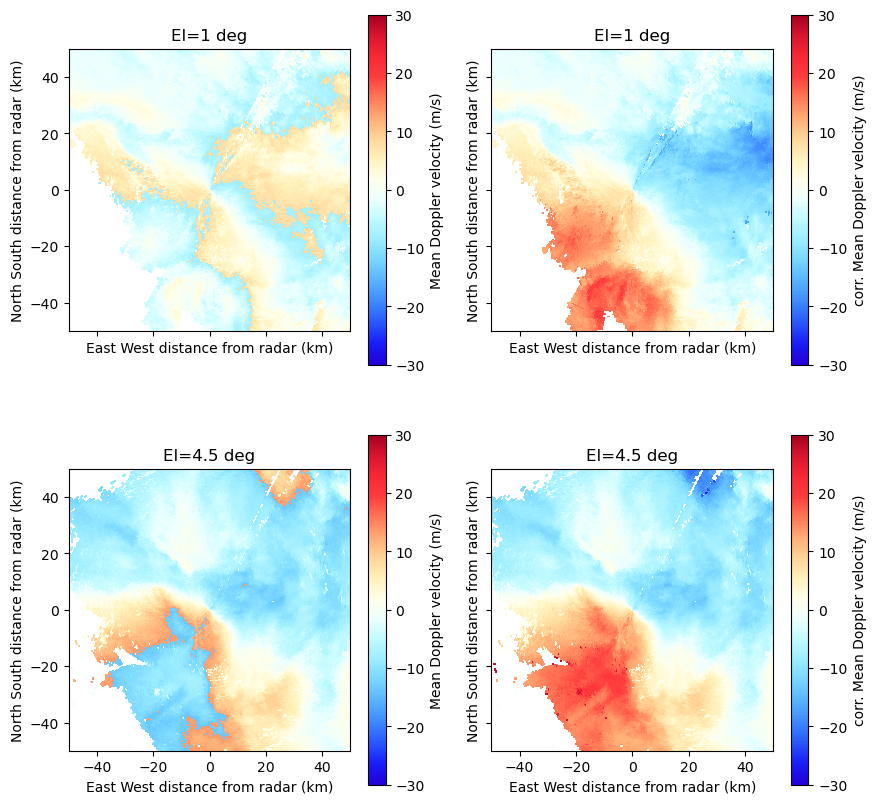

In [11]:
fig, ax = plt.subplots(2,2, figsize=(10,10), sharex= True, sharey=True)
ax = ax.ravel()
display = pyart.graph.RadarDisplay(radar_merged)
display.plot_ppi('velocity', 2, vmin=-30, vmax=30., ax = ax[0], title='El=1 deg',
                 colorbar_label = 'Mean Doppler velocity (m/s)')
display.plot_ppi('corrected_velocity', 2, vmin=-30, vmax=30., title='El=1 deg',
                      ax = ax[1], colorbar_label = 'corr. Mean Doppler velocity (m/s)')
display.plot_ppi('velocity', 6, vmin=-30, vmax=30., ax = ax[2], title='El=4.5 deg',
                 colorbar_label = 'Mean Doppler velocity (m/s)')
display.plot_ppi('corrected_velocity', 6, vmin=-30, vmax=30., title='El=4.5 deg',
                      ax = ax[3], colorbar_label = 'corr. Mean Doppler velocity (m/s)')
ax[0].set_xlim([-50,50])
ax[0].set_ylim([-50,50])
for a in ax:
    a.set_aspect('equal', 'box')

In [12]:
zmin = 500
zmax = 8000
ymin= xmin = -100000
ymax = xmax = 100000
lat = float(radar.latitude['data'])
lon = float(radar.longitude['data'])
alt = float(radar.altitude['data'])
# number of grid points in cappi
cappi_res_h = 500
cappi_res_v = 500
ny = int((ymax-ymin)/cappi_res_h)+1
nx = int((xmax-xmin)/cappi_res_h)+1
nz = int((zmax-zmin)/cappi_res_v)+1

cappi_zh = pyart.map.grid_from_radars(radar_merged, grid_shape=(nz, ny, nx),
        grid_limits=((zmin, zmax), (ymin, ymax),
                     (xmin, xmax)),
        fields=['reflectivity'])

/tmp/ipykernel_71960/2859974444.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lat = float(radar.latitude['data'])
/tmp/ipykernel_71960/2859974444.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lon = float(radar.longitude['data'])
/tmp/ipykernel_71960/2859974444.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alt = float(radar.altitude['data'])


/scratch/mch/fackerma/miniforge3/envs/testenv/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lines.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


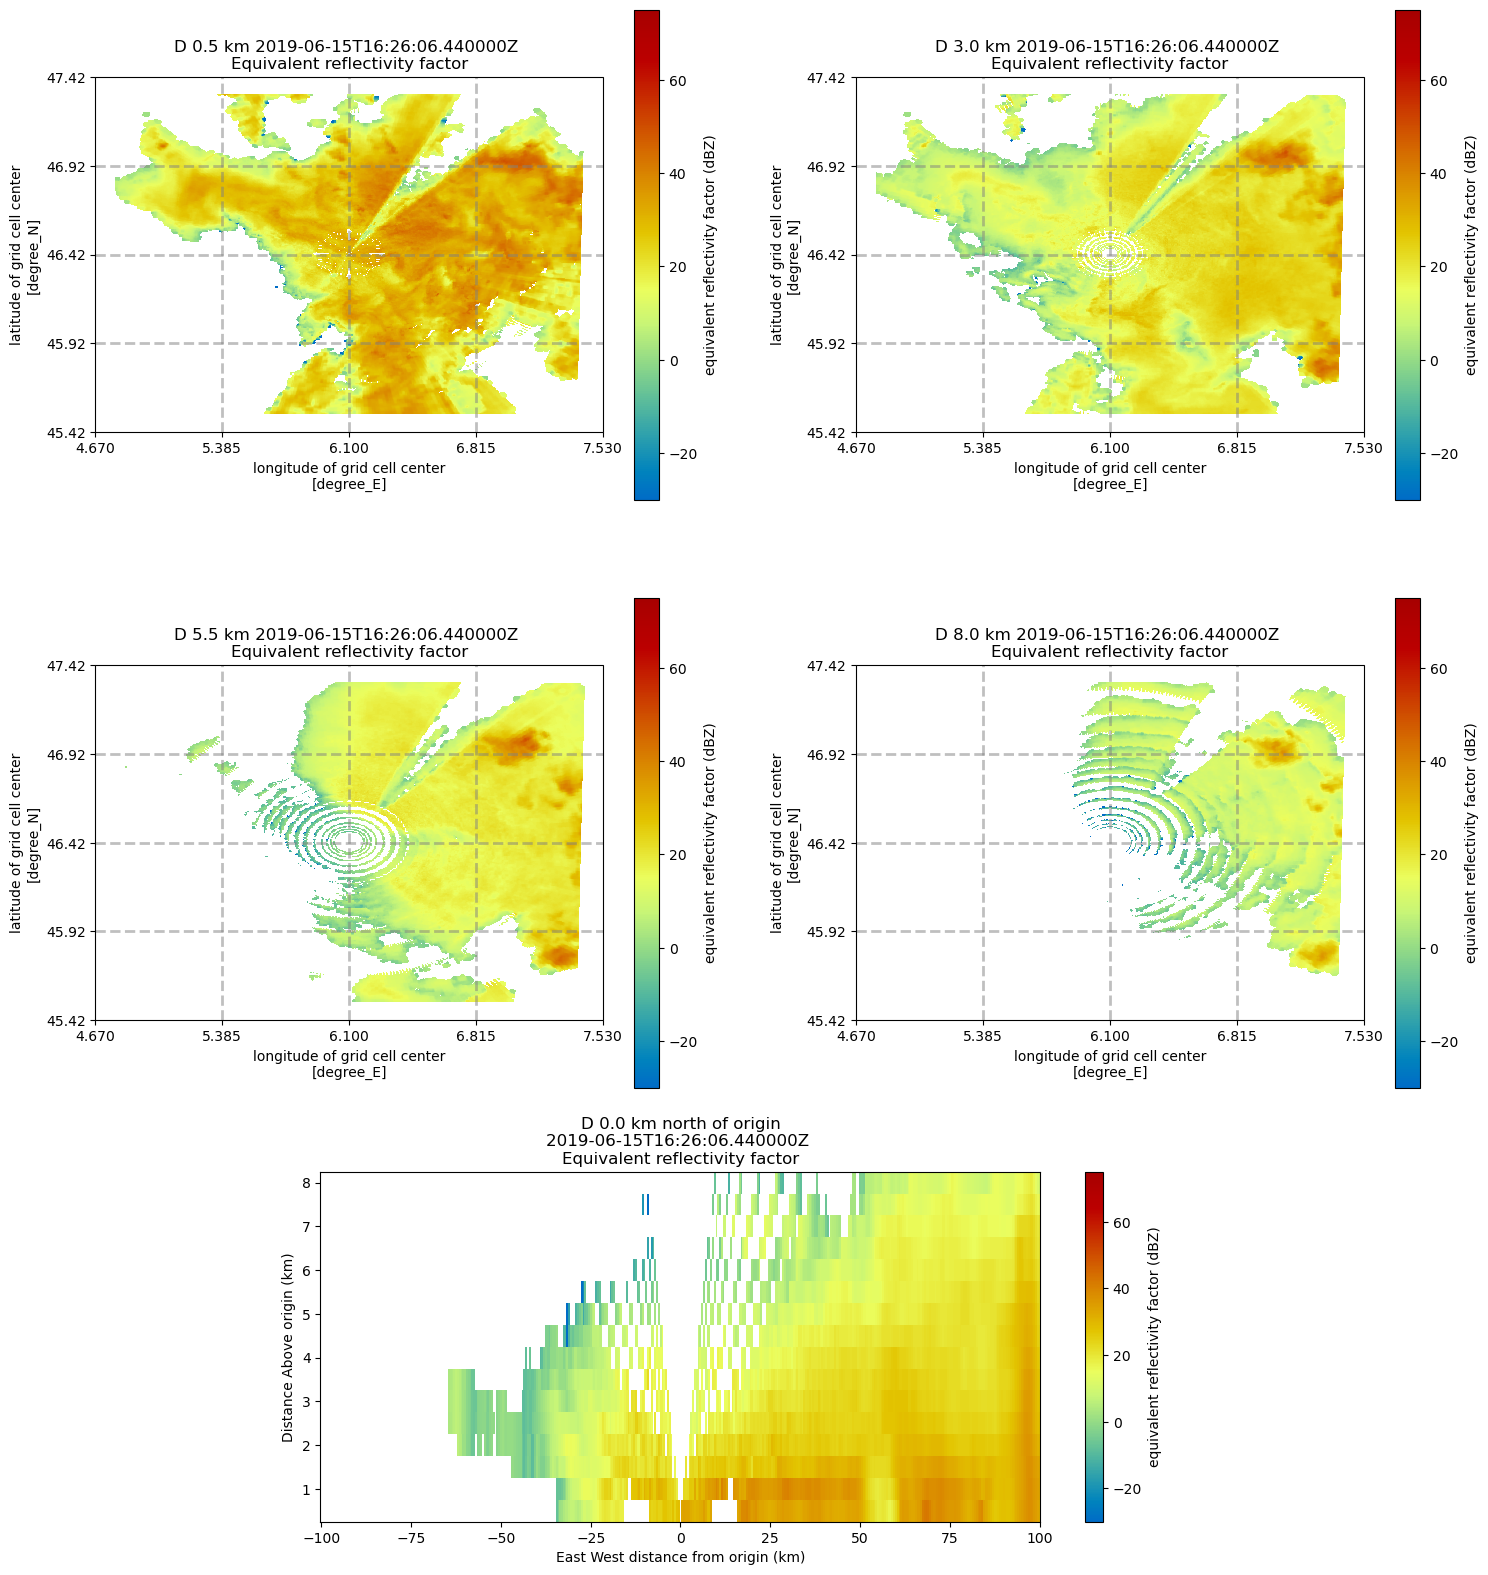

In [13]:
display = pyart.graph.GridMapDisplay(cappi_zh)
projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(18,14))
ax = plt.subplot(221, projection = projection)
display.plot_grid('reflectivity',0, ax = ax, projection = projection)
ax = plt.subplot(222, projection = projection)
display.plot_grid('reflectivity',5, ax = ax, projection = projection)
ax = plt.subplot(223, projection = projection)
display.plot_grid('reflectivity',10, ax = ax, projection = projection)
ax = plt.subplot(224, projection = projection)
display.plot_grid('reflectivity',15, ax = ax, projection = projection)

ax = fig.add_axes([0.25, -0.20, .5, .25])
display.plot_latitude_slice('reflectivity', lon=lon, lat=lat, ax = ax)

(0.0, 100.0)

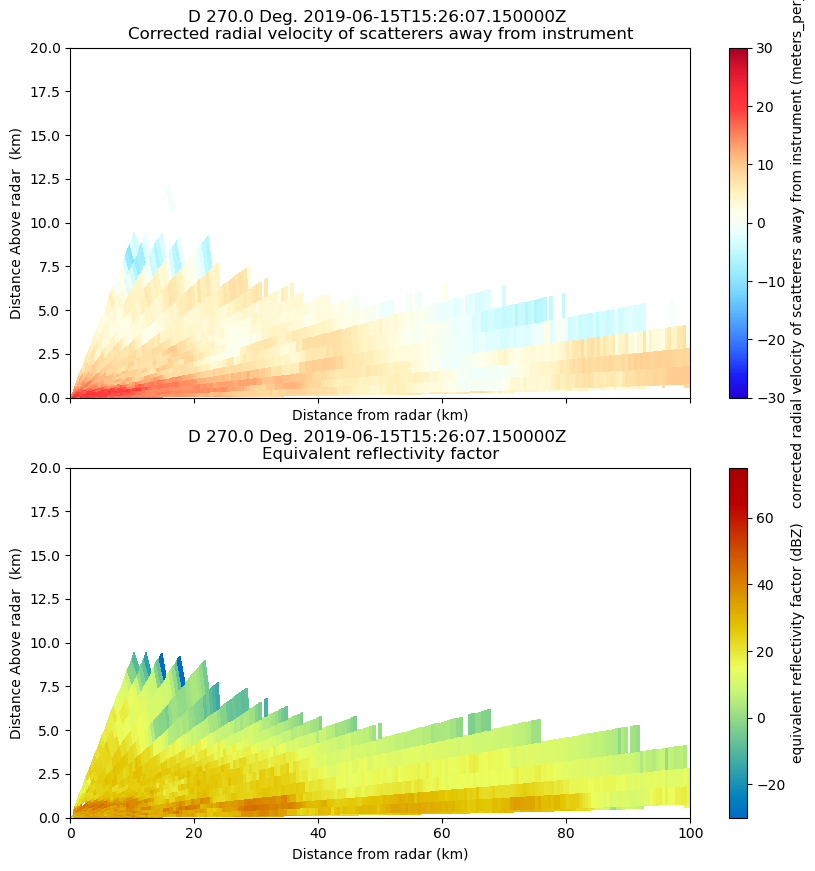

In [5]:
pseudorhi = pyart.util.cross_section_ppi(radar_merged, [270])

display = pyart.graph.RadarDisplay(pseudorhi)
fig, ax = plt.subplots(2,1, sharex=True,sharey=True, figsize= (10,10))
display.plot_rhi('corrected_velocity', ax = ax[0], vmin = -30, vmax = 30)
display.plot_rhi('reflectivity', ax = ax[1])
ax[0].set_ylim([0,20])
ax[0].set_xlim([0,100])